In [202]:
# Some useful imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [203]:
class BlackScholes:
    """
    Simulates asset price paths under the Black-Scholes model.

    Parameters
    ----------
    mu : float
        The drift (expected return) of the asset.
    sigma : float
        The volatility of the asset.
    """

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def generate(self, x, T, N, n):
        """
        Generate simulated price paths using the discrete-time Black-Scholes model.

        Parameters
        ----------
        x : float
            Initial asset price.
        T : float
            Maturity (in years).
        N : int
            Number of time steps.
        n : int
            Number of simulated paths.

        Returns
        -------
        S : ndarray of shape (n, N)
            Simulated asset price trajectories.
        """
        S = np.zeros((n, N))
        S[:, 0] = x
        dt = T / N

        for i in range(1, N):
            S[:, i] = S[:, i-1] + S[:, i-1] * (
                self.mu * dt + self.sigma * np.sqrt(dt) * np.random.randn(n)
            )

        return S


<Figure size 1200x800 with 0 Axes>

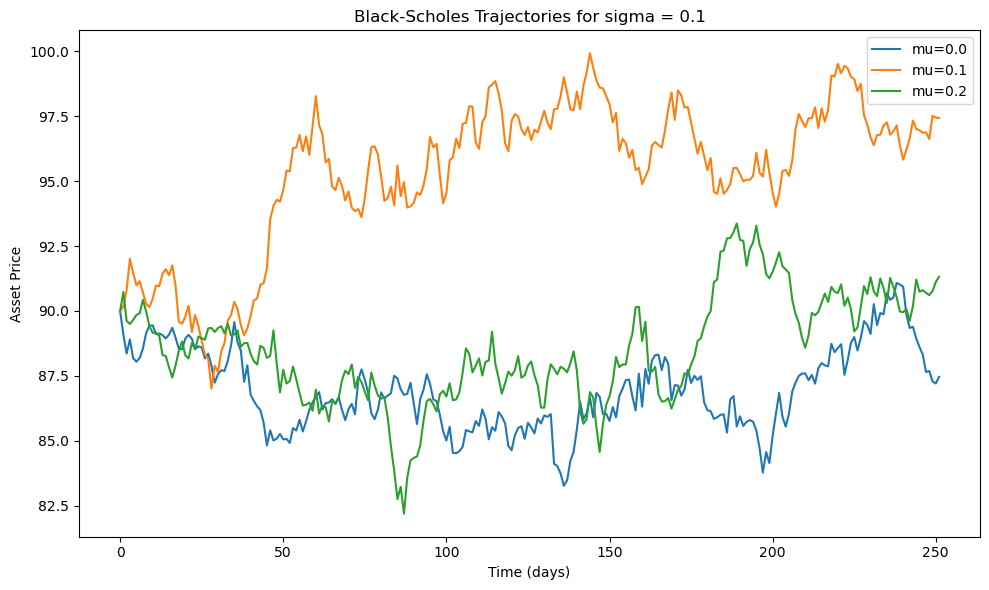

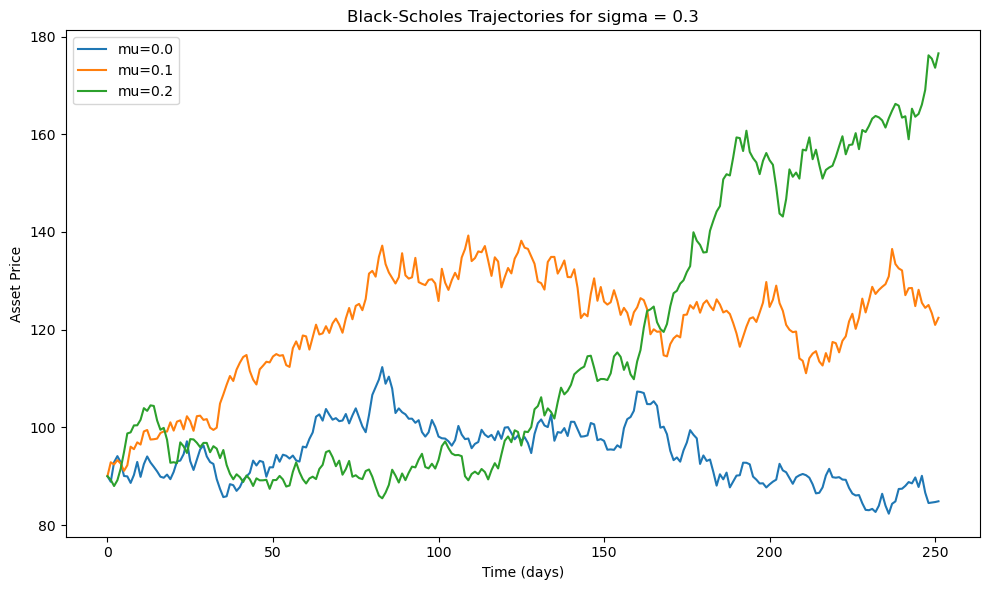

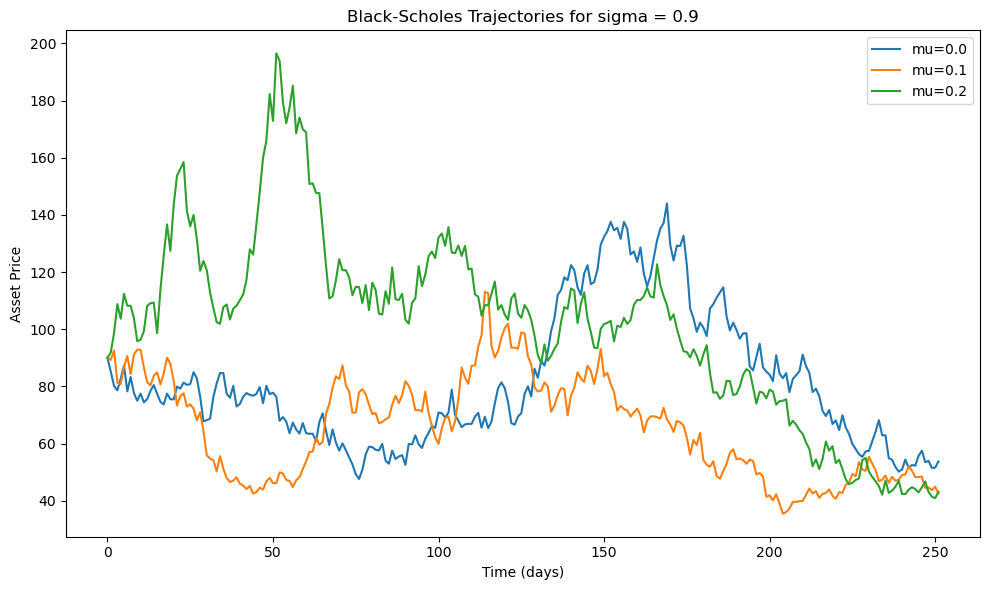

In [204]:
# Parameters
r = 0.05      # Risk-free interest rate
x = 90        # Initial asset price

n = 1         # Number of trajectories
N = 252       # Number of time steps (daily steps in one year)
T = 1         # Maturity in years

# Lists of mu and sigma values to test
mu_list = [0.0, 0.1, 0.2]         # Different drifts (expected returns)
sigma_list = [0.1, 0.3, 0.9]      # Different volatilities

plt.figure(figsize=(12, 8))

# Generate and plot trajectories for each sigma with varying mu
for sigma in sigma_list:
    plt.figure(figsize=(10, 6))
    for mu in mu_list:
        model = BlackScholes(mu, sigma)
        trajectory = model.generate(x, T, N, n)[0]  # Take the first (and only) simulation
        plt.plot(trajectory, label=f"mu={mu}")
    
    plt.title(f"Black-Scholes Trajectories for sigma = {sigma}")
    plt.xlabel("Time (days)")
    plt.ylabel("Asset Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Prix du call européen
$$C(t, x) = xN(d_1(T-t, x))-Ke^{-r(T-t)} N(d_2 (T-t, x))$$
$$d_1(t,x) = \frac{1}{\sigma \sqrt{T-t}} \left( \log(x/K) + (r+\sigma^2/2)(T-t) \right), \ \ \ d_2(t,x)=d_1(t,x)-\sigma \sqrt{T-t}$$

In [205]:
def C(trajectories, T, N, K, r, sigma):
    """
    Computes the price of a European call option at each time step for multiple simulated asset paths
    under the Black-Scholes model.

    Parameters
    ----------
    trajectories : ndarray of shape (n, N)
        Simulated asset price trajectories, where `n` is the number of paths and `N` is the number of time steps.
    T : float
        Maturity of the option (in years).
    N : int
        Number of time steps.
    K : float
        Strike price of the option.
    r : float
        Risk-free interest rate.
    sigma : float
        Volatility of the underlying asset.

    Returns
    -------
    p : ndarray of shape (n, N)
        Theoretical European call option prices at each time step and for each trajectory.
    """
    n = trajectories.shape[0]
    dt = T / N
    time_grid = np.linspace(0, T, N)
    p = np.zeros((n, N))

    for i in range(N - 1):
        tau = T - time_grid[i]
        S_t = trajectories[:, i]

        d1_val = (np.log(S_t / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
        d2_val = d1_val - sigma * np.sqrt(tau)

        p[:, i] = S_t * norm.cdf(d1_val) - K * np.exp(-r * tau) * norm.cdf(d2_val)

    # Final value at maturity: option payoff
    p[:, -1] = np.maximum(trajectories[:, -1] - K, 0)

    return p

In [240]:
mu = r
sigma = 0.1
n = 1
N = 252
T = 1

In [241]:
model = BlackScholes(mu, sigma)
trajectory = model.generate(x, T, N, n)

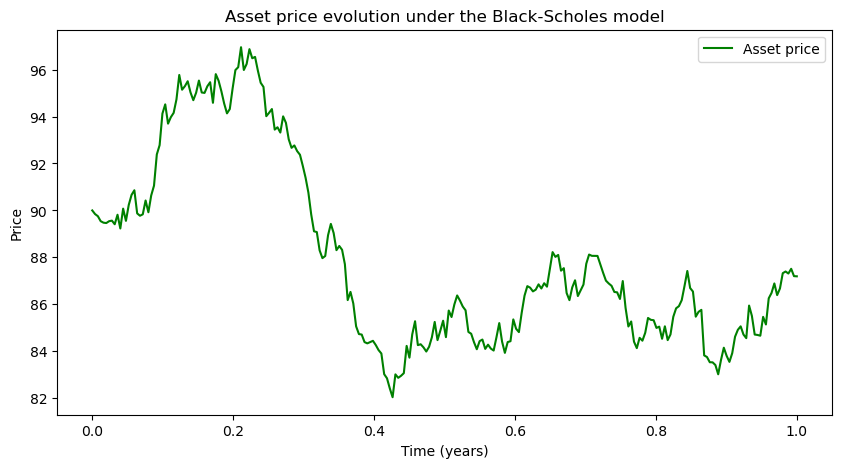

In [242]:
time_grid = np.linspace(0, T, N)

plt.figure(figsize=(10, 5))
plt.plot(time_grid, trajectory[0], label='Asset price', color='green')
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.title("Asset price evolution under the Black-Scholes model")
plt.legend()
plt.show()

In [243]:
K = 90
prices = C(trajectory, T, N, K, r, sigma)[0, :]

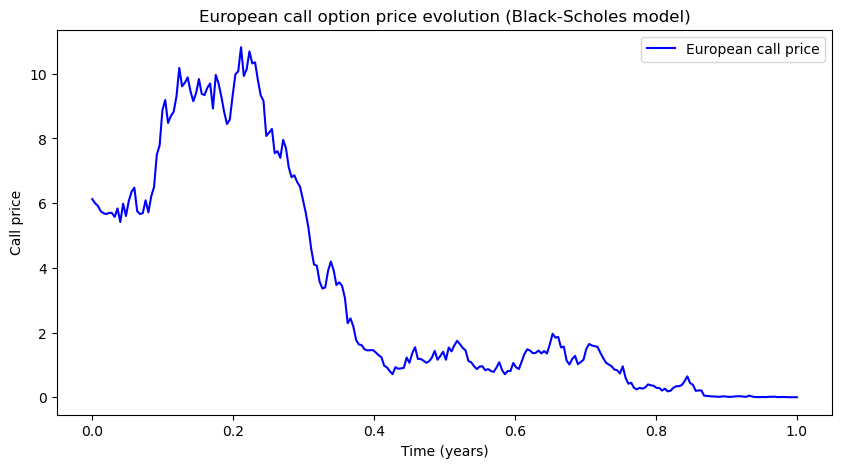

In [244]:
time_grid = np.linspace(0, T, N)

plt.figure(figsize=(10, 5))
plt.plot(time_grid, prices, label='European call price', color='blue')
plt.xlabel("Time (years)")
plt.ylabel("Call price")
plt.title("European call option price evolution (Black-Scholes model)")
plt.legend()
plt.show()

# Couverture

In [245]:
def d1(theta, x, T, K, r, sigma):
    """
    Computes the d1 term in the Black-Scholes formula.

    Parameters
    ----------
    theta : float or ndarray
        Time to maturity (T - t).
    x : float or ndarray
        Current asset price.
    T : float
        Total maturity (used for compatibility, but not needed in the formula directly).
    K : float
        Strike price of the option.
    r : float
        Risk-free interest rate.
    sigma : float
        Volatility of the underlying asset.

    Returns
    -------
    d1 : float or ndarray
        Value(s) of d1 corresponding to the inputs.
    """
    theta = np.asarray(theta)
    x = np.asarray(x)

    numerator = np.log(x / K) + (r + 0.5 * sigma**2) * theta
    denominator = sigma * np.sqrt(theta)

    return numerator / denominator

In [246]:
def hedging(trajectories, C0, T, N, K, r, sigma):
    """
    Computes the delta-hedging strategy and portfolio value for multiple simulated asset price trajectories
    under the Black-Scholes model.

    Parameters
    ----------
    trajectories : ndarray of shape (n, N)
        Simulated asset price paths.
    C0 : float or ndarray of shape (n,)
        Initial price of the European call option for each trajectory.
    T : float
        Maturity of the option (in years).
    N : int
        Number of time steps.
    K : float
        Strike price of the option.
    r : float
        Risk-free interest rate.
    sigma : float
        Volatility of the underlying asset.

    Returns
    -------
    H0 : ndarray of shape (n, N)
        Risk-free (cash) position over time for each trajectory.
    H : ndarray of shape (n, N)
        Delta (asset quantity) over time for each trajectory.
    V : ndarray of shape (n, N)
        Total value of the hedging portfolio over time for each trajectory.
    """
    n = trajectories.shape[0]
    dt = T / N

    H0 = np.zeros((n, N))  # Risk-free (cash) component
    H = np.zeros((n, N))   # Delta (asset holding)
    V = np.zeros((n, N))   # Total value of the portfolio

    time_grid = np.linspace(0, T, N)
    tau_grid = T - time_grid
    tau_grid[N - 1] += 1e-4  # Avoid division by zero at maturity

    # Initial hedge at time t = 0
    tau = tau_grid[0]
    d1_0 = d1(tau, trajectories[:, 0], T, K, r, sigma)
    H[:, 0] = norm.cdf(d1_0)
    H0[:, 0] = C0 - H[:, 0] * trajectories[:, 0]
    V[:, 0] = H[:, 0] * trajectories[:, 0] + H0[:, 0]

    for i in range(1, N):
        tau = tau_grid[i]
        S_i = trajectories[:, i]

        # Let cash grow at the risk-free rate
        H0[:, i] = H0[:, i - 1] * np.exp(r * dt)

        # Recalculate delta
        d1_i = d1(tau, S_i, T, K, r, sigma)
        H[:, i] = norm.cdf(d1_i)

        # Adjust cash according to the change in delta
        H0[:, i] -= (H[:, i] - H[:, i - 1]) * S_i

        # Compute total value of the portfolio
        V[:, i] = H[:, i] * S_i + H0[:, i]

    return H0, H, V



In [247]:
(H0, H, val) = hedging(trajectory, prices[0], T, N, K, r, sigma)

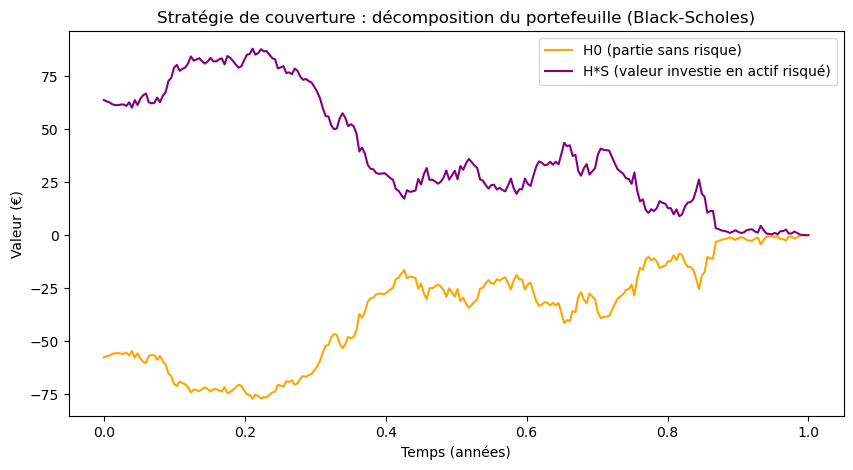

In [248]:
time_grid = np.linspace(0, T, N)

plt.figure(figsize=(10, 5))
plt.plot(time_grid, H0[0], label='H0 (partie sans risque)', color='orange')
plt.plot(time_grid, H[0] * trajectory[0], label='H*S (valeur investie en actif risqué)', color='purple')
plt.xlabel("Temps (années)")
plt.ylabel("Valeur (€)")
plt.title("Stratégie de couverture : décomposition du portefeuille (Black-Scholes)")
plt.legend()
plt.show()


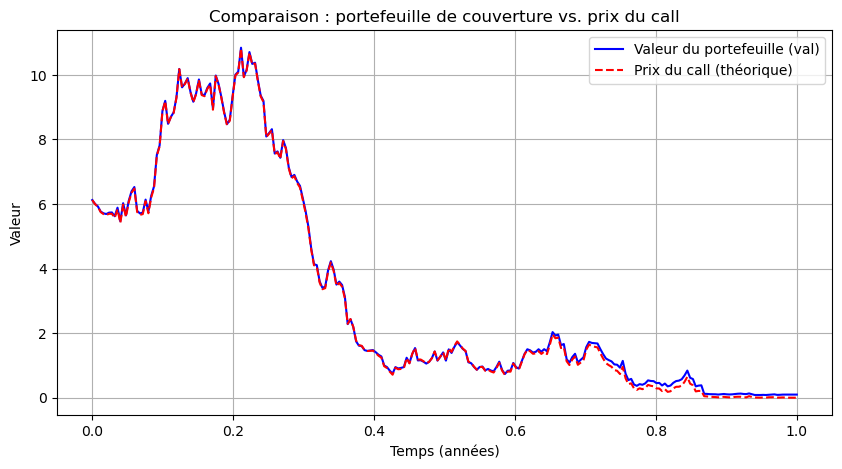

In [249]:
# Tracé de val et prices sur le même graphique
plt.figure(figsize=(10, 5))
plt.plot(time_grid, val[0], label='Valeur du portefeuille (val)', color='blue')
plt.plot(time_grid, prices, label='Prix du call (théorique)', color='red', linestyle='--')
plt.xlabel("Temps (années)")
plt.ylabel("Valeur")
plt.title("Comparaison : portefeuille de couverture vs. prix du call")
plt.legend()
plt.grid(True)
plt.show()

# Risque rédisuel

In [250]:
def risk(T, N, n_simul, mu, sigma, x, K, r):
    """
    Computes the hedging error for a European call option using a delta hedging strategy
    under the Black-Scholes model.

    Parameters
    ----------
    T : float
        Maturity of the option (in years).
    N : int
        Number of time steps.
    n_simul : int
        Number of simulated asset price trajectories.
    mu : float
        Drift (expected return) of the asset.
    sigma : float
        Volatility of the asset.
    x : float
        Initial asset price.
    K : float
        Strike price of the European call option.
    r : float
        Risk-free interest rate.

    Returns
    -------
    R : ndarray of shape (n_simul,)
        Hedging error at maturity for each simulated path, defined as:
        portfolio value - option payoff.
    """
    model = BlackScholes(mu, sigma)

    # Simulate asset price trajectories
    trajectories = model.generate(x, T, N, n_simul)

    # Compute the theoretical call price along each trajectory
    C_all = C(trajectories, T, N, K, r, sigma)

    # Get the initial option price for each path
    C0 = C_all[:, 0]

    # Perform delta hedging for each path
    H0, H, V = hedging(trajectories, C0, T, N, K, r, sigma)

    # Compute payoff of the European call at maturity
    payoff = np.maximum(trajectories[:, -1] - K, 0)

    # Hedging error: difference between hedged portfolio and actual payoff
    R = V[:, -1] - payoff

    return R

In [251]:
n_simul = 10000
R = risk(T, N, n_simul, mu, sigma, x, K, r)

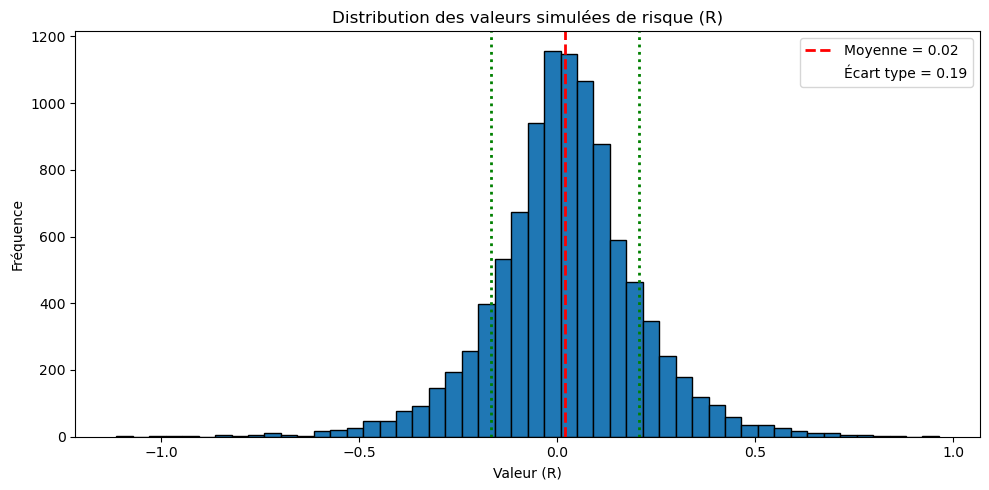

In [252]:
# Calcul de la moyenne et de l'écart type
mean_R = np.mean(R)
std_R = np.std(R)

# Tracé de l'histogramme
plt.figure(figsize=(10, 5))
plt.hist(R, bins=50, edgecolor='black')

# Ajout de la moyenne (avec légende)
plt.axvline(mean_R, color='red', linestyle='dashed', linewidth=2, label=f'Moyenne = {mean_R:.2f}')

# Ajout des lignes ±1 écart type (sans légende)
plt.axvline(mean_R + std_R, color='green', linestyle='dotted', linewidth=2)
plt.axvline(mean_R - std_R, color='green', linestyle='dotted', linewidth=2)

# Ajout manuel de l'écart type dans la légende
plt.plot([], [], ' ', label=f'Écart type = {std_R:.2f}')

# Titres et légende
plt.title("Distribution des valeurs simulées de risque (R)")
plt.xlabel("Valeur (R)")
plt.ylabel("Fréquence")
plt.legend()
plt.tight_layout()
plt.show()


In [253]:
print(np.mean(R))

0.019514095028936727


In [ ]:
N_values = [12, 52, 252, 1638]

T = 1
n_simul = 10000

R_squared_means = np.zeros(len(N_values))

for i, N in enumerate(N_values):
    R_simul = risk(T, N, n_simul, mu, sigma, x, K, r)
    R_squared_means[i] = np.mean(R_simul**2)


In [ ]:
print(R_squared_means)

# Défaut de couverture

In [ ]:
# Simulation et affichage
n_points_list = [100, 1000]
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for idx, n_points in enumerate(n_points_list):
    # Simuler les trajectoires
    model = BlackScholes(mu, sigma)
    trajectories = model.generate(x, T, N, n_points)

    # Appliquer la stratégie de couverture
    H0, H, val = hedging(trajectories, prices[0], T, N, K, r, sigma)

    # Valeurs terminales
    S_T = trajectories[:, -1]
    V_T = val[:, -1]

    # Payoff théorique
    x_vals = np.linspace(min(S_T), max(S_T), 200)
    payoff = np.maximum(x_vals - K, 0)

    # Tracer
    axs[idx].plot(x_vals, payoff, color='gray', linestyle='--', label='Payoff $(S_T - K)_+$')
    axs[idx].scatter(S_T, V_T, alpha=0.6, s=10, label='$(S_T, V_T)$')
    axs[idx].set_title(f"{n_points} simulations")
    axs[idx].set_xlabel("Taux de change terminal $S_T$")
    if idx == 0:
        axs[idx].set_ylabel("Valeur finale du portefeuille $V_T$")
    axs[idx].legend()

plt.suptitle("Couverture d'une option call : comparaison $(S_T, V_T)$ avec le payoff", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("couverture_comparaison_100_vs_1000.png", dpi=300)
plt.show()
